# **IST 736: Text Mining**

**Homework #2**




# **Introduction**

Due to recent emergence of powerful large language models like ChatGPT and Gemini, artificial intelligence has been an incredibly popular topic over the last few years. Many people feel that this powerful technology will greatly benefit society, creating new opportunities within our personal and professional lives. Some have much less positive opinions, as conerns around job replacement and the availablility for upskilling remain prominent. Here, I'll be exploring a small corpus of tweets to gauge the current public sentiment toward AI within the social media space using sentiment analysis tools in Python, specifically the Support Vector Machines, Naive Bayes and Logicstic Regression machine learning algorithms. The first thing we'll do is install and load the appropriate libraies for this analysis.

In [2]:
pip install seaborn spacy nltk vaderSentiment pandas matplotlib contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.9 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import re
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from textblob import TextBlob

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle


# **Data**

This data set was obtained via Kaggle at https://www.kaggle.com/datasets/msfalif404/generative-ai-opinion-dataset-on-twitter.

This dataset contains opinions about Generative AI collected from social media platform Twitter. The data was gathered from 2021 to 2024 using various relevant keywords, such as:

* generative ai opinion
* generative ai thought
* generative ai controversy
* generative ai impact
* generative ai ethics
* generative ai risks
* generative ai vs human
* ai generated misinformation
* generative ai backlash
* generative ai opportunities
* generative ai policy
* AIFailure
* ai helps human
* future of generative ai

The dataset aims to provide insights into public opinions about Generative AI, highlighting both its opportunities and challenges, and is expected to be valuable for research or analysis on public opinion, ethics, policies, and the impacts of Generative AI.


The original dataset consists of 3 columns with 22064 rows:


*  **full_text** :
Contains the full text of tweets expressing opinions or discussions about Generative AI.

*  **tweet_url** :
Contains a unique URL that redirects users to the original tweet on Twitter.

*  **username** :
Contains the Twitter username of the person who posted the tweet.


I'll only be using about 10 samples/documents from the original dataset, as a random sample had previously been  loaded into a corpus folder called 'tweet_corpus'.




**Loading the corpus**

In [4]:
import zipfile
import os
import pandas as pd
from google.colab import drive

# **Step 1: Mount Google Drive**
drive.mount('/content/drive', force_remount=True)

# **Step 2: Specify Paths**
# Path to the zipped file in Google Drive
zip_path = '/content/drive/My Drive/tweet_corpus/tweet_corpus.zip'

# Folder to extract the contents into
extract_to = '/content/drive/My Drive/tweet_corpus'

Mounted at /content/drive


In [5]:
# **Step 3: Unzip the File**
if os.path.exists(zip_path):
    print(f"Unzipping {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted contents of {zip_path} into {extract_to}.")
else:
    print(f"Zip file not found at {zip_path}.")

Zip file not found at /content/drive/My Drive/tweet_corpus/tweet_corpus.zip.


In [6]:
# **Step 4: Verify Extracted Contents**
print(f"Contents of '{extract_to}':")
print(os.listdir(extract_to))

# Check for nested folders
corpus_folder = extract_to
for root, dirs, files in os.walk(extract_to):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")

    # If .txt files are in a subdirectory, update the corpus_folder
    if files and any(file.endswith('.txt') for file in files):
        corpus_folder = root
        break

Contents of '/content/drive/My Drive/tweet_corpus':
['tweet_corpus']
Directory: /content/drive/My Drive/tweet_corpus
Subdirectories: ['tweet_corpus']
Files: []
Directory: /content/drive/My Drive/tweet_corpus/tweet_corpus
Subdirectories: []
Files: ['tweet_8.txt', 'tweet_9.txt', 'tweet_6.txt', 'tweet_3.txt', 'tweet_7.txt', 'tweet_0.txt', 'tweet_4.txt', 'tweet_1.txt', 'tweet_5.txt', 'tweet_2.txt']


In [7]:
# **Step 5: Load Text Files into a Corpus with Complete Paths**
corpus = []
file_names = []
file_paths = []

# Iterate through the folder to read text files
for file_name in os.listdir(corpus_folder):
    if file_name.endswith('.txt'):
        file_path = os.path.join(corpus_folder, file_name)
        file_paths.append(file_path)  # Store the complete path
        file_names.append(file_name)  # Store the file name
        with open(file_path, 'r', encoding='utf-8') as file:
            corpus.append(file.read())

# Print results
print("Full list of file paths:")
print(file_paths)
print("Full list of file names:")
print(file_names)

Full list of file paths:
['/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_8.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_9.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_6.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_3.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_7.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_0.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_4.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_1.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_5.txt', '/content/drive/My Drive/tweet_corpus/tweet_corpus/tweet_2.txt']
Full list of file names:
['tweet_8.txt', 'tweet_9.txt', 'tweet_6.txt', 'tweet_3.txt', 'tweet_7.txt', 'tweet_0.txt', 'tweet_4.txt', 'tweet_1.txt', 'tweet_5.txt', 'tweet_2.txt']


In [8]:
# **Step 6: Create a DataFrame**
data = pd.DataFrame({
    'file_name': file_names,  # File names
    'full_text': corpus         # Text content
})

# Display the results
print(f"Loaded {len(data)} text files into the corpus.")
data.head(10)

Loaded 10 text files into the corpus.


,file_name,full_text
0,tweet_8.txt,assistant? NLP helps machines understand and r...
1,tweet_9.txt,What is Generative AI? What is it Used For? #G...
2,tweet_6.txt,@NickJRishwain There's about to be such a delu...
3,tweet_3.txt,In case you're interested reading biographical...
4,tweet_7.txt,Ready to explore the future of technology? Div...
5,tweet_0.txt,@RodneyRobaina @ByronDonalds Do you know how m...
6,tweet_4.txt,The future of generative AI on higher ed campu...
7,tweet_1.txt,Presti uses generative AI to improve product p...
8,tweet_5.txt,HIRING DEVELOPERS. AS THE POPULAR SAYING GOES ...
9,tweet_2.txt,Nvidia CEO Jensen Huang Discusses Leadership F...


In [9]:
# Create ground truth label for performance comparison
data['binary_label'] = ['neg', 'pos', 'neg', 'pos', 'pos',
                 'pos', 'pos', 'pos', 'pos', 'neg']

# Adjust display settings
pd.set_option('display.max_colwidth', None)

data.head(10)

,file_name,full_text,binary_label
0,tweet_8.txt,assistant? NLP helps machines understand and respond to human language making conversations smoother. - Robotics: Picture a robot that moves and interacts with its environment. Robotics combines AI with physical machines to perform tasks,neg
1,tweet_9.txt,What is Generative AI? What is it Used For? #GenAI is paving the way for innovation across various sectors offering unprecedented opportunities for content creation efficiency improvements and personalized customer experiences.#ai #openAI #datascience https://t.co/Q9dSndlJ21 https://t.co/wVWZkUWy41,pos
2,tweet_6.txt,@NickJRishwain There's about to be such a deluge of AI generated misinformation trash... Twitter is going to just be a series of AI generated feeds for whatever anyone feels like tapping into.,neg
3,tweet_3.txt,In case you're interested reading biographical essays written by generative AI visit https://t.co/P3Lh3FGiLe,pos
4,tweet_7.txt,Ready to explore the future of technology? Dive into generative AI solutions that can transform your ideas into reality! Check out our services to learn more! https://t.co/X1OVpXrUJn #GenerativeAI #ArtificialIntelligence #MachineLearning #AIApplications #AISolutions,pos
5,tweet_0.txt,@RodneyRobaina @ByronDonalds Do you know how many lies and misinformation AI generated images . Yet the only one convicted is Trump.,pos
6,tweet_4.txt,The future of generative AI on higher ed campuses is bright. But are you looking at it all wrong? Learn why leaders at #EDU24 say starting with your use cases then identifying the solution is key. https://t.co/ULyeW7uSKo https://t.co/v3n5SKgtBi,pos
7,tweet_1.txt,Presti uses generative AI to improve product photography in the furniture industry If you ve ever bought a sofa online have you thought about the homes you can see in the background of the product shots? When it s time to release a new https://t.co/9KEFQBW8cK https://t.co/kvIpmQouV5,pos
8,tweet_5.txt,HIRING DEVELOPERS. AS THE POPULAR SAYING GOES AI HELPS THOSE WHO HELP THEMSELVES At Ekke we provide the most human felt work for your project #developer #software #softwarecompany #programmer #devin #cognition #ai #technology Lockdown MTN and Telecel AirtelTigo #internet https://t.co/vziJMDRv84,pos
9,tweet_2.txt,Nvidia CEO Jensen Huang Discusses Leadership Future of Generative AI https://t.co/HWVjQ0wepu,neg


Before we get to scrubbing the data for exploration, I want to first analyze the tweet hashtags and mentions before they're removed for better distinguishablity.

In [10]:
from collections import Counter
from nltk.corpus import stopwords

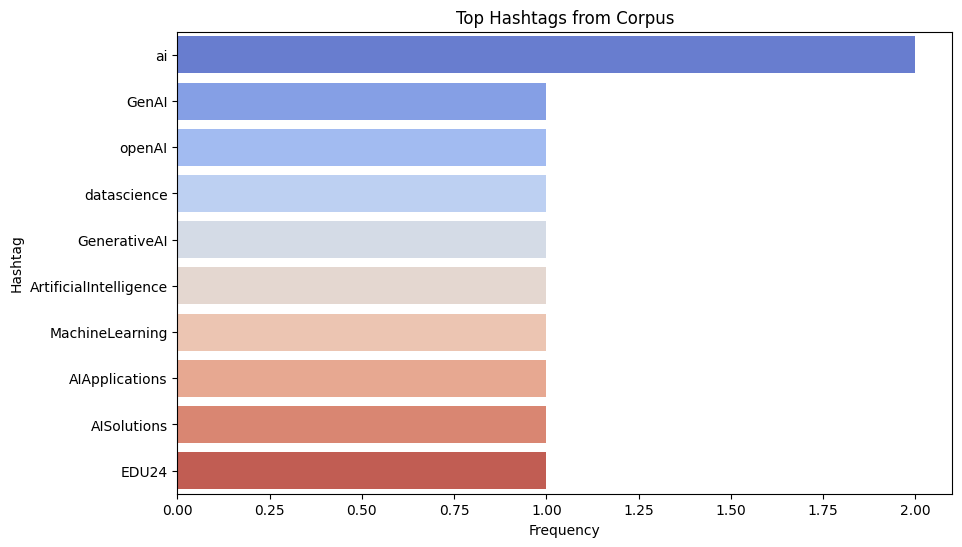

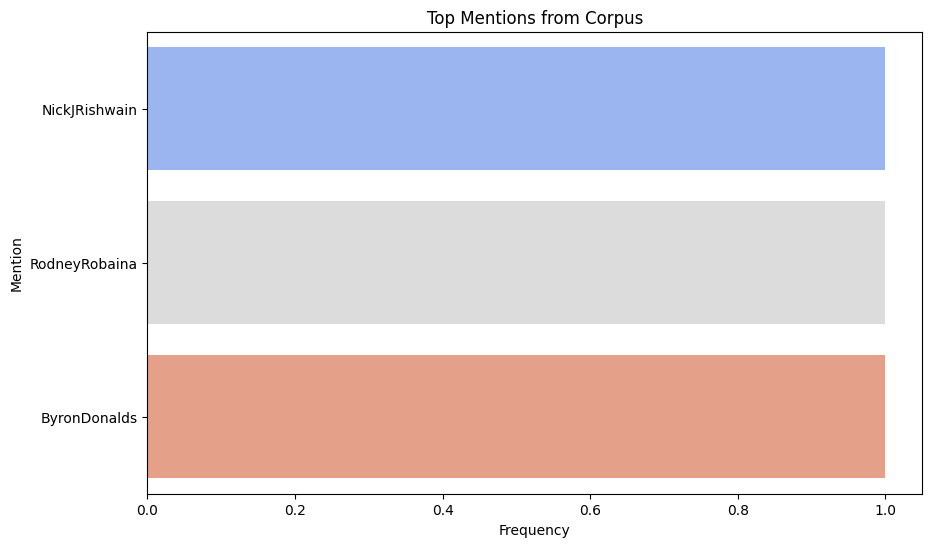

In [11]:
# Extract hashtags and mentions before cleaning
raw_text = " ".join(data['full_text'])

hashtags = re.findall(r"#(\w+)", raw_text)
mentions = re.findall(r"@(\w+)", raw_text)

# Count and plot
hashtag_freq = Counter(hashtags).most_common(10)
mention_freq = Counter(mentions).most_common(10)

hashtag_df = pd.DataFrame(hashtag_freq, columns=['Hashtag', 'Frequency'])
mention_df = pd.DataFrame(mention_freq, columns=['Mention', 'Frequency'])

# Plot for hashtags
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Hashtag', data=hashtag_df, hue='Hashtag', palette='coolwarm', dodge=False, legend=False)
plt.title("Top Hashtags from Corpus")
plt.show()

# Plot for mentions
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Mention', data=mention_df, hue='Mention', palette='coolwarm', dodge=False, legend=False)
plt.title("Top Mentions from Corpus")
plt.show()

**Initial Preprocessing**

Here we'll clean up the data by removing urls, mentions, hashtags and special charcaters. We'll also lemmatize the text so the contractions can be resolved to their root words.

In [12]:
import contractions

# Preprocess the text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = contractions.fix(text)  # Expand contractions
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower().strip()  # Convert to lowercase and strip spaces

In [13]:
# Clean the text and add to dt
data['cleaned_text'] = data['full_text'].apply(clean_text)

# Compare text to ensure cleaning steps were applied
data['full_text']

,full_text
0,assistant? NLP helps machines understand and respond to human language making conversations smoother. - Robotics: Picture a robot that moves and interacts with its environment. Robotics combines AI with physical machines to perform tasks
1,What is Generative AI? What is it Used For? #GenAI is paving the way for innovation across various sectors offering unprecedented opportunities for content creation efficiency improvements and personalized customer experiences.#ai #openAI #datascience https://t.co/Q9dSndlJ21 https://t.co/wVWZkUWy41
2,@NickJRishwain There's about to be such a deluge of AI generated misinformation trash... Twitter is going to just be a series of AI generated feeds for whatever anyone feels like tapping into.
3,In case you're interested reading biographical essays written by generative AI visit https://t.co/P3Lh3FGiLe
4,Ready to explore the future of technology? Dive into generative AI solutions that can transform your ideas into reality! Check out our services to learn more! https://t.co/X1OVpXrUJn #GenerativeAI #ArtificialIntelligence #MachineLearning #AIApplications #AISolutions
5,@RodneyRobaina @ByronDonalds Do you know how many lies and misinformation AI generated images . Yet the only one convicted is Trump.
6,The future of generative AI on higher ed campuses is bright. But are you looking at it all wrong? Learn why leaders at #EDU24 say starting with your use cases then identifying the solution is key. https://t.co/ULyeW7uSKo https://t.co/v3n5SKgtBi
7,Presti uses generative AI to improve product photography in the furniture industry If you ve ever bought a sofa online have you thought about the homes you can see in the background of the product shots? When it s time to release a new https://t.co/9KEFQBW8cK https://t.co/kvIpmQouV5
8,HIRING DEVELOPERS. AS THE POPULAR SAYING GOES AI HELPS THOSE WHO HELP THEMSELVES At Ekke we provide the most human felt work for your project #developer #software #softwarecompany #programmer #devin #cognition #ai #technology Lockdown MTN and Telecel AirtelTigo #internet https://t.co/vziJMDRv84
9,Nvidia CEO Jensen Huang Discusses Leadership Future of Generative AI https://t.co/HWVjQ0wepu


In [14]:
# Display the cleaned text
data['cleaned_text']

,cleaned_text
0,assistant nlp helps machines understand and respond to human language making conversations smoother robotics picture a robot that moves and interacts with its environment robotics combines ai with physical machines to perform tasks
1,what is generative ai what is it used for genai is paving the way for innovation across various sectors offering unprecedented opportunities for content creation efficiency improvements and personalized customer experiencesai openai datascience
2,there is about to be such a deluge of ai generated misinformation trash twitter is going to just be a series of ai generated feeds for whatever anyone feels like tapping into
3,in case you are interested reading biographical essays written by generative ai visit
4,ready to explore the future of technology dive into generative ai solutions that can transform your ideas into reality check out our services to learn more generativeai artificialintelligence machinelearning aiapplications aisolutions
5,do you know how many lies and misinformation ai generated images yet the only one convicted is trump
6,the future of generative ai on higher ed campuses is bright but are you looking at it all wrong learn why leaders at edu24 say starting with your use cases then identifying the solution is key
7,presti uses generative ai to improve product photography in the furniture industry if you ve ever bought a sofa online have you thought about the homes you can see in the background of the product shots when it s time to release a new
8,hiring developers as the popular saying goes ai helps those who help themselves at ekke we provide the most human felt work for your project developer software softwarecompany programmer devin cognition ai technology lockdown mtn and telecel airteltigo internet
9,nvidia ceo jensen huang discusses leadership future of generative ai


**Exploratory Data Analysis**

Here we'll look at the distribution of text lengths, word counts, average word lengths, polarity and sentiment labels, in addition to creating WordClouds for unigram, bigrams and trigrams.

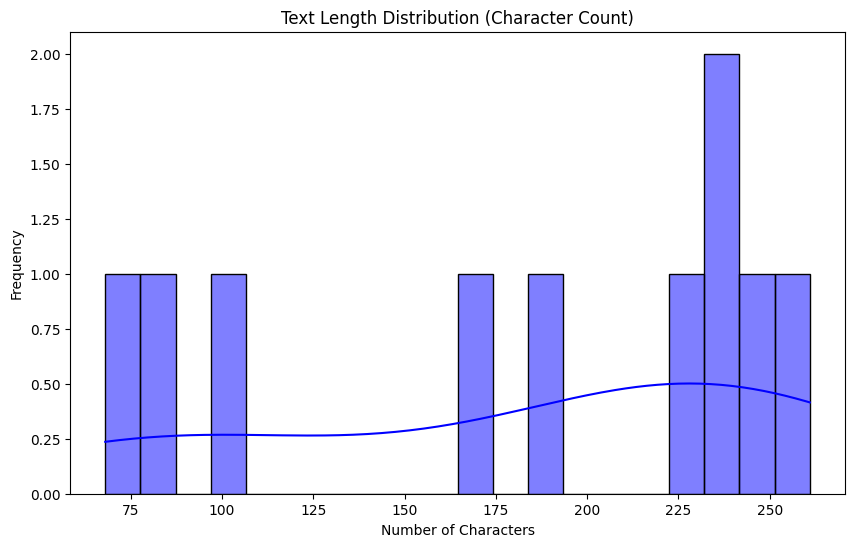

In [15]:
### 1. Text Length Distribution (Character Count)
data['text_length'] = data['cleaned_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=20, kde=True, color="blue")
plt.title("Text Length Distribution (Character Count)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

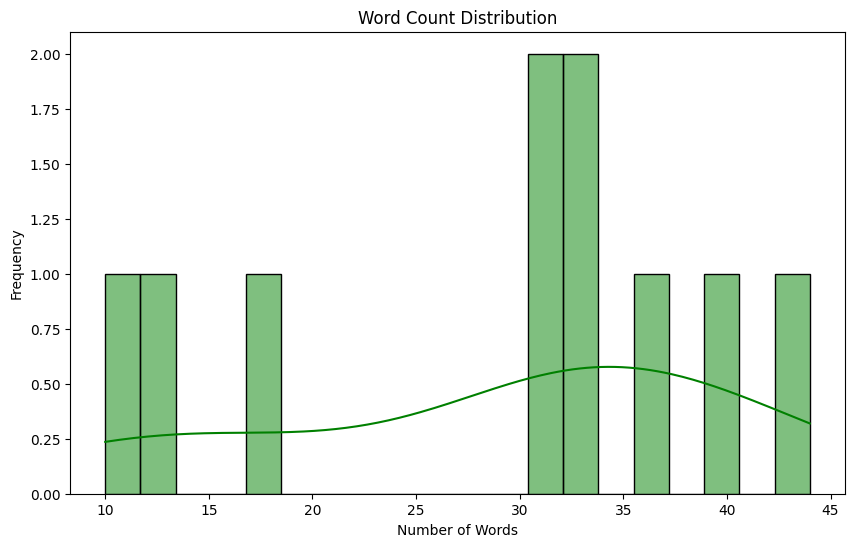

In [16]:
### 2. Word Count Distribution
data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=20, kde=True, color="green")
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

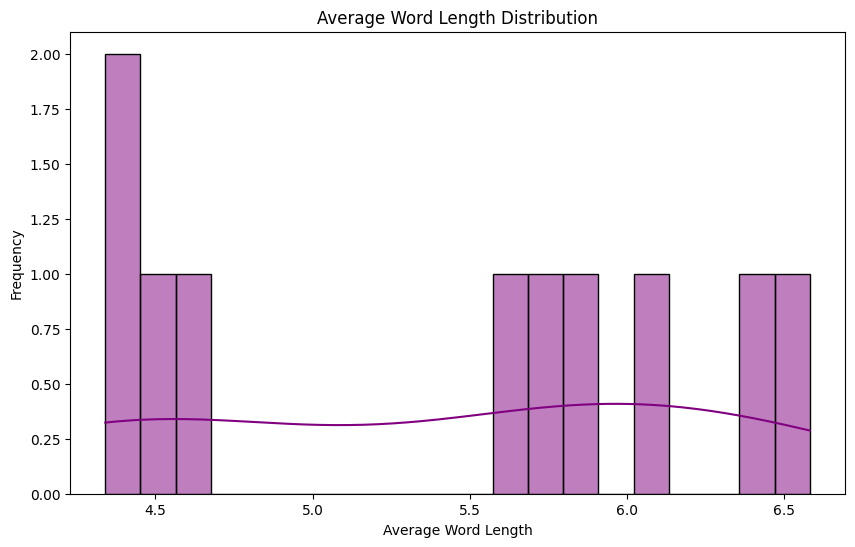

In [17]:
### 3. Average Word Length Distribution
data['avg_word_length'] = data['cleaned_text'].apply(
    lambda x: sum(len(word) for word in x.split()) / len(x.split())
)

plt.figure(figsize=(10, 6))
sns.histplot(data['avg_word_length'], bins=20, kde=True, color="purple")
plt.title("Average Word Length Distribution")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.show()

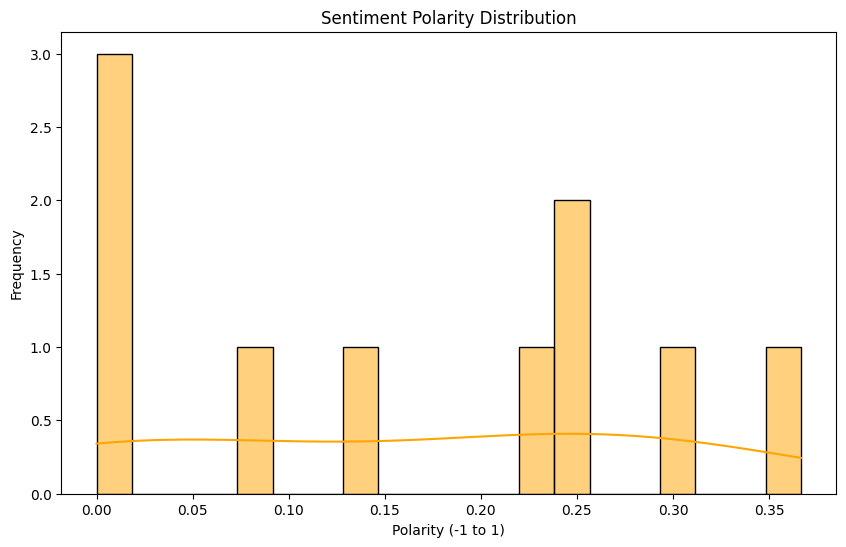

In [18]:
### 4. Polarity Distribution
data['polarity'] = data['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.histplot(data['polarity'], bins=20, kde=True, color="orange")
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity (-1 to 1)")
plt.ylabel("Frequency")
plt.show()

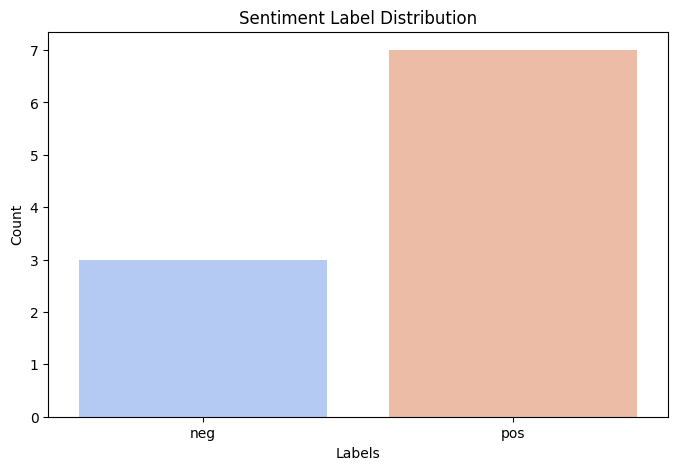

In [19]:
### 5. Sentiment Label Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='binary_label', data=data, hue='binary_label', palette="coolwarm")
plt.title("Sentiment Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


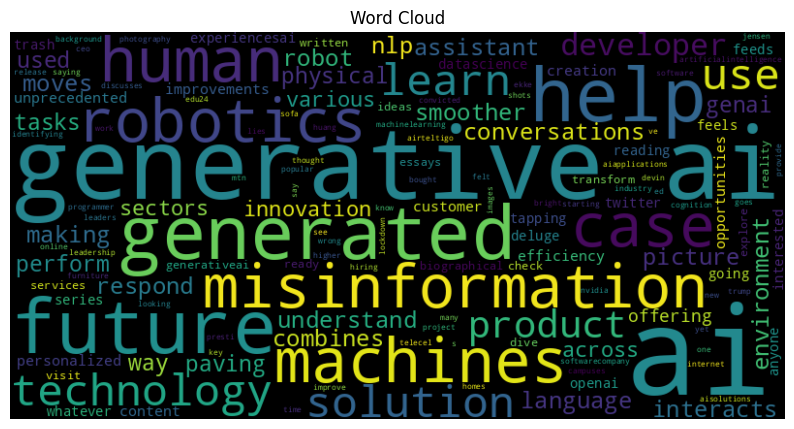

In [20]:
### 6. Word Cloud
all_text = " ".join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

In [21]:
# Load spaCy for preprocessing
nlp = spacy.load("en_core_web_sm")

# Custom tokenizer for text preprocessing for word cloud
def preprocess_text_for_wc(text):
    doc = nlp(text.lower())
    return [token for token in doc if not token.is_stop and not token.is_punct]


In [22]:
# Preprocess all text and calculate word frequencies
data['processed_text'] = data['cleaned_text'].apply(preprocess_text_for_wc)
all_words = [str(word) for tokens in data['processed_text'] for word in tokens]  # Ensure tokens are strings
word_freq = Counter(all_words)


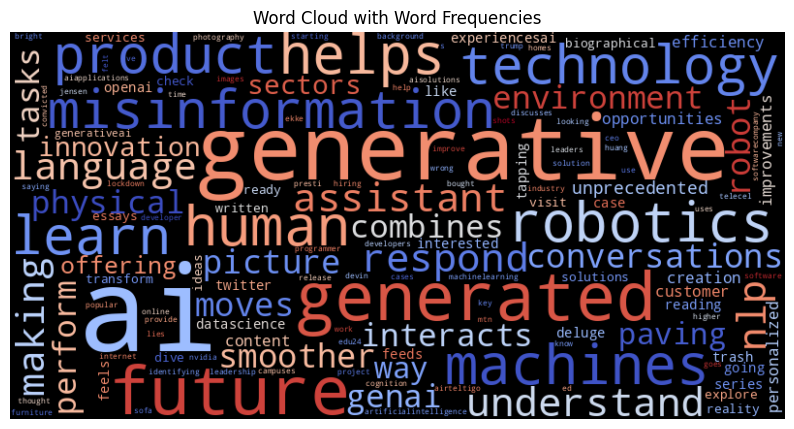

In [23]:
# Generate WordCloud using word frequencies
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="black",
    colormap="coolwarm"
).generate_from_frequencies(word_freq)
# Visualize WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud with Word Frequencies")
plt.show()

In [24]:
def preprocess_text_to_string(text):
    doc = nlp(text.lower())
    # Return lemmatized tokens as strings
    return [token.text for token in doc if not token.is_punct]


In [25]:
# EDA: N-gram analysis (bigrams and trigrams)
def generate_ngrams(texts, n):
    """
    Generates n-grams and their frequencies from a list of documents.

    Args:
        texts (list): A list of strings, where each string is a preprocessed document.
        n (int): The size of the n-grams to generate.

    Returns:
        Counter: A Counter object with n-grams as keys and their frequencies as values.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(texts)
    # Create a Counter of n-grams
    ngram_counts = Counter(dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)))
    return ngram_counts

In [26]:
# Preprocess text
data['processed_text_to_string'] = data['cleaned_text'].apply(preprocess_text_to_string)

# Flatten the processed text back into a list of strings
processed_text_list = [" ".join(tokens) for tokens in data['processed_text_to_string']]

Top 10 Bigrams: [('generative ai', 6), ('ai generated', 3), ('future of', 3), ('in the', 2), ('of ai', 2), ('of generative', 2), ('the future', 2), ('what is', 2), ('about the', 1), ('about to', 1)]


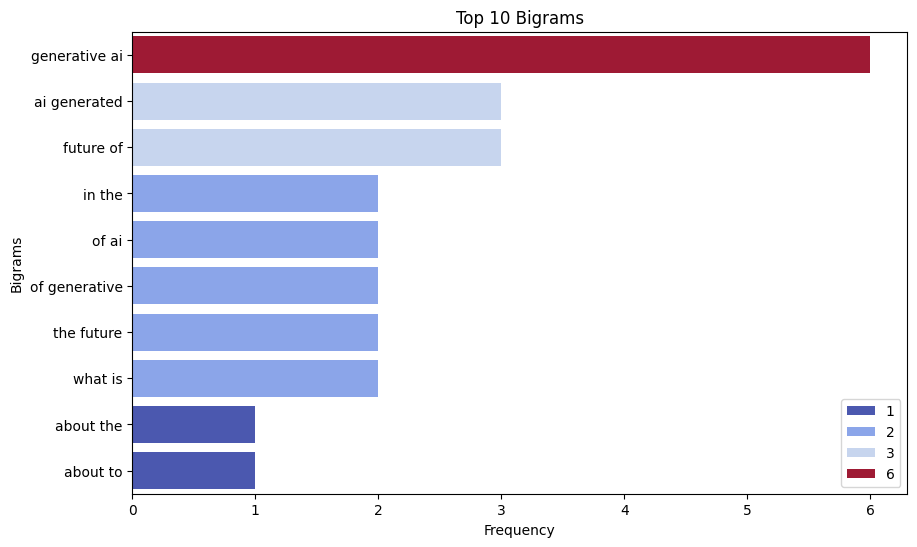

In [27]:
# Generate bigrams from the preprocessed text
bigrams = generate_ngrams(processed_text_list, n=2)

# Print the top 10 bigrams
print("Top 10 Bigrams:", bigrams.most_common(10))

# Extract the top 10 bigrams for visualization
top_bigrams = bigrams.most_common(10)
labels, values = zip(*top_bigrams)

# Plot the bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=labels, hue=values, palette="coolwarm")
plt.title("Top 10 Bigrams")
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.show()

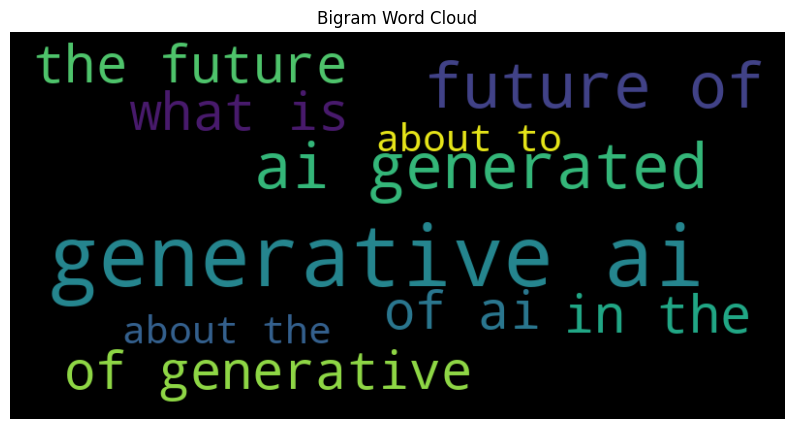

In [28]:
# Word cloud visualization for bigrams
bigram_wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(dict(top_bigrams))
plt.figure(figsize=(10, 6))
plt.imshow(bigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Bigram Word Cloud")
plt.show()

Top 10 Trigrams: [('future of generative', 2), ('of ai generated', 2), ('of generative ai', 2), ('the future of', 2), ('about the homes', 1), ('about to be', 1), ('across various sectors', 1), ('ai generated feeds', 1), ('ai generated images', 1), ('ai generated misinformation', 1)]


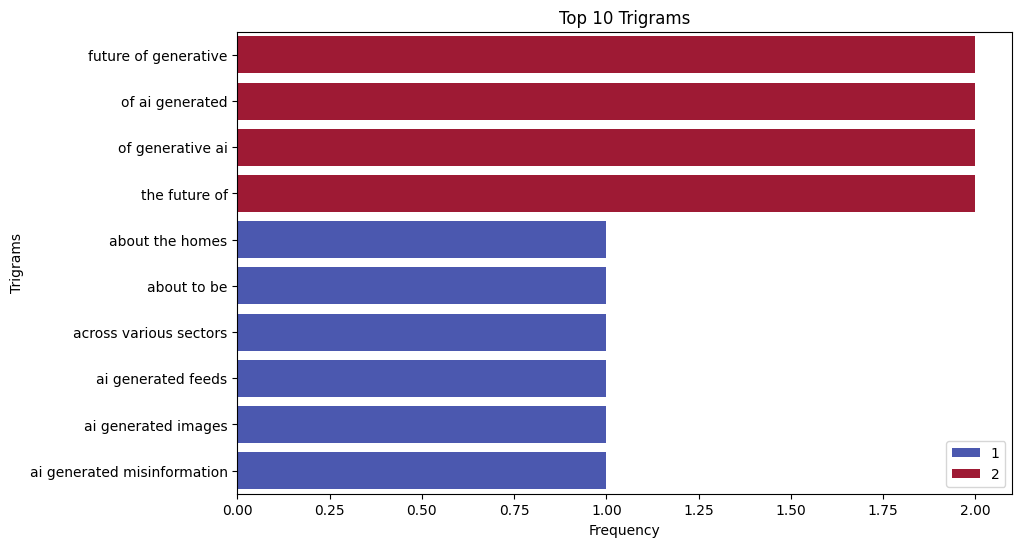

In [29]:
# Generate trigrams from the preprocessed text
trigrams = generate_ngrams(processed_text_list, n=3)

# Print the top 10 trigrams
print("Top 10 Trigrams:", trigrams.most_common(10))

# Extract the top 10 trigrams for visualization
top_trigrams = trigrams.most_common(10)
labels, values = zip(*top_trigrams)

# Plot the trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=values, y=labels, hue=values, palette="coolwarm")
plt.title("Top 10 Trigrams")
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.show()

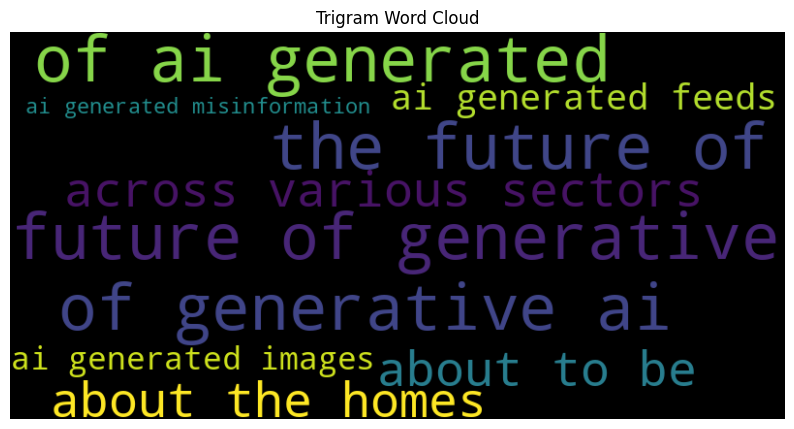

In [30]:
trigram_wordcloud = WordCloud(width=800, height=400, background_color="black").generate_from_frequencies(dict(top_trigrams))
plt.figure(figsize=(10, 6))
plt.imshow(trigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Trigram Word Cloud")
plt.show()



# **Methods and Models**

To address this classification problem, we will employ three machine learning models: Support Vector Machines (SVM), Multinomial Naive Bayes (MultinomialNB), and Logistic Regression (LR). Each model offers different mechanisms for learning patterns in the data and predicting outcomes.



**Support Vector Machines (SVM):**

SVM is a powerful supervised learning algorithm used for classification tasks. It works by finding the optimal hyperplane that separates data points of different classes with the largest margin. SVM can handle both linear and non-linear decision boundaries through the use of kernels (e.g., linear, radial basis function).


**Multinomial Naive Bayes (MultinomialNB):**

MultinomialNB is a probabilistic classifier that uses Bayes' theorem to predict class membership. It assumes that the features (e.g., words or n-grams) are conditionally independent given the class label. This model is particularly effective for text classification tasks where word frequency is important.


**Logistic Regression:**

Logistic Regression is a linear classifier that predicts the probability of a data point belonging to a particular class. It does so by modeling the relationship between the features and the log-odds of the class labels. Despite its simplicity, Logistic Regression is highly effective for binary classification problems and can be extended to multi-class problems using techniques like one-vs-rest



# **Experimental Design**

After completing EDA, we can now begin modeling the data. We'll first start by lemmatizing the text, so the words can be resolved to their roots prior to stop word removal, then the data will be split. Various model implementations will be set in an attempt to find the optimal configuration for performance, using the pipeline, cross validation and param_grid functionality available in sklearn..

In [31]:
# Function to preprocess text: lemmatize
def preprocess(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [32]:
data['lemmatized_text'] = data['cleaned_text'].apply(preprocess)

In [33]:
# Compare the lemmatized and cleaned text to ensure application
data['cleaned_text'].head()

,cleaned_text
0,assistant nlp helps machines understand and respond to human language making conversations smoother robotics picture a robot that moves and interacts with its environment robotics combines ai with physical machines to perform tasks
1,what is generative ai what is it used for genai is paving the way for innovation across various sectors offering unprecedented opportunities for content creation efficiency improvements and personalized customer experiencesai openai datascience
2,there is about to be such a deluge of ai generated misinformation trash twitter is going to just be a series of ai generated feeds for whatever anyone feels like tapping into
3,in case you are interested reading biographical essays written by generative ai visit
4,ready to explore the future of technology dive into generative ai solutions that can transform your ideas into reality check out our services to learn more generativeai artificialintelligence machinelearning aiapplications aisolutions


In [34]:
data['lemmatized_text'].head()

,lemmatized_text
0,assistant nlp help machine understand and respond to human language make conversation smoother robotic picture a robot that move and interact with its environment robotic combine ai with physical machine to perform task
1,what be generative ai what be it use for genai be pave the way for innovation across various sector offer unprecedented opportunity for content creation efficiency improvement and personalize customer experiencesai openai datascience
2,there be about to be such a deluge of ai generate misinformation trash twitter be go to just be a series of ai generate feed for whatever anyone feel like tap into
3,in case you be interested read biographical essay write by generative ai visit
4,ready to explore the future of technology dive into generative ai solution that can transform your idea into reality check out our service to learn more generativeai artificialintelligence machinelearning aiapplication aisolution


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into training and testing sets
# Using the 'text' column as features and 'label' as targets
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatized_text'],  # Feature: lemmatized text column
    data['binary_label'],  # Target: label column
    test_size=0.4,
    random_state=42,  # Ensures reproducibility
    stratify=data['binary_label']  # Ensures balanced label distribution in train/test sets
)

# Display the split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 6
Testing set size: 4


In [36]:
# Testing stopwords
#my_stops = ['a','i','he', 'she', 'we', 'you', 'the', 'to', 'in', 'if', 'at', 'of', 'on', 'your', 'by','and', 'but', 'when', 'who', 'why', 'with', 'work', 'write', 've']

In [37]:
"""from sklearn.naive_bayes import ComplementNB

# Train a classifier
model = ComplementNB()
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred,zero_division=0))"""

'from sklearn.naive_bayes import ComplementNB\n\n# Train a classifier\nmodel = ComplementNB()\nmodel.fit(X_train_tfidf, y_train)\n\n# Evaluate the model\ny_pred = model.predict(X_test_tfidf)\nprint(classification_report(y_test, y_pred,zero_division=0))'

In [38]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Creating custom stop words that repeatedly performed poorly (on nb model)
custom_stop_words = ['case', 'developer', 'help', 'human', 'machine', 'nvidia', 'robotic']

# Combine default and custom stop words
combined_stop_words = list(set(ENGLISH_STOP_WORDS).union(custom_stop_words))

In [39]:
# Trouble shooting issue with combined stopwords
print(type(combined_stop_words))


<class 'list'>


In [40]:
# Testing TfidfVectorizer separately to see if this causes error
vectorizer = TfidfVectorizer(stop_words=combined_stop_words)
X_tfidf = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out())


['ai' 'assistant' 'background' 'biographical' 'buy' 'combine' 'content'
 'conversation' 'convict' 'creation' 'customer' 'datascience' 'deluge'
 'efficiency' 'environment' 'essay' 'experiencesai' 'feed' 'feel'
 'furniture' 'genai' 'generate' 'generative' 'home' 'image' 'improve'
 'improvement' 'industry' 'innovation' 'interact' 'interested' 'just'
 'know' 'language' 'lie' 'like' 'make' 'misinformation' 'new' 'nlp'
 'offer' 'online' 'openai' 'opportunity' 'pave' 'perform' 'personalize'
 'photography' 'physical' 'picture' 'presti' 'product' 'read' 'release'
 'respond' 'robot' 'sector' 'series' 'shot' 'smoother' 'sofa' 'tap' 'task'
 'think' 'time' 'trash' 'trump' 'twitter' 'understand' 'unprecedented'
 'use' 'various' 've' 'visit' 'way' 'write']


In [41]:
# Define model pipelines and parameter grids

models = {
    'Naive Bayes': {
        'pipeline': Pipeline([
            ('vectorizer', vectorizer),  # stop_words=my_stops, max_features=75, min_df, stop_words='english', ngram_range=(1, 2), max_features=50, TfidfVectorizer(stop_words=combined_stop_words)
            ('classifier', MultinomialNB())
        ]),
        'param_grid': {
            'vectorizer__max_features': [10, 25, 50],
            'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'classifier__alpha': [0.01, 0.1, 0.5, 1.0]
        }
    },
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', LogisticRegression(max_iter=100))
        ]),
        'param_grid': {
            'vectorizer__max_features': [10, 25, 50],
            'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'classifier__C': [0.01, 0.1, 1.0, 10.0],
            'classifier__penalty': ['l2']
        }
    },
    'SVM': {
        'pipeline': Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', SVC())
        ]),
        'param_grid': {
            'vectorizer__max_features': [10, 25, 50],
            'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'classifier__C': [0.01, 0.1, 1.0, 10.0],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
            'classifier__degree': [2, 3, 4]
        }
    }
}

In [42]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=42)

In [43]:
# Train each model
results = {}
for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model_info['pipeline'],
        param_grid=model_info['param_grid'],
        cv=cv,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)  # Train on the training set
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'grid_search': grid_search
    }


Training Naive Bayes...
Fitting 6 folds for each of 36 candidates, totalling 216 fits
Training Logistic Regression...
Fitting 6 folds for each of 36 candidates, totalling 216 fits
Training SVM...
Fitting 6 folds for each of 1620 candidates, totalling 9720 fits



Evaluating Naive Bayes on the test set...
Naive Bayes Metrics:
Accuracy: 0.75
F1 Score: 0.86
Recall: 1.00


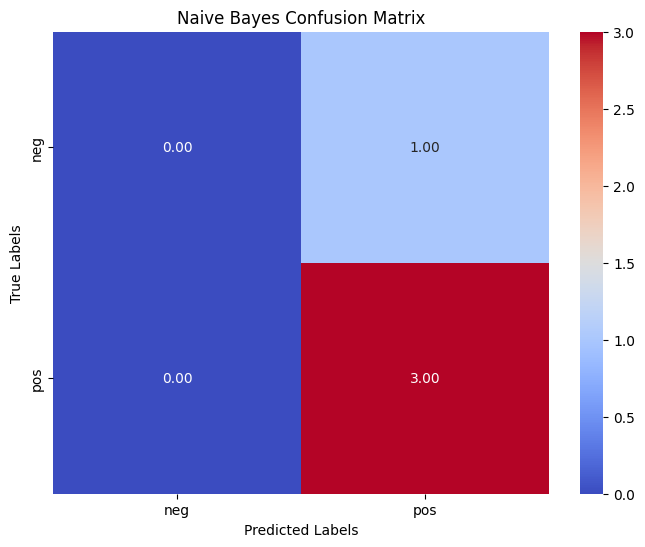


Evaluating Logistic Regression on the test set...
Logistic Regression Metrics:
Accuracy: 0.75
F1 Score: 0.86
Recall: 1.00


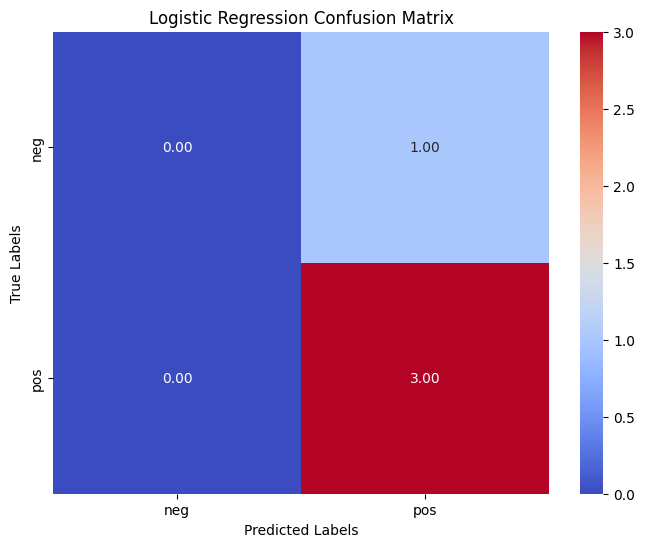


Evaluating SVM on the test set...
SVM Metrics:
Accuracy: 0.75
F1 Score: 0.86
Recall: 1.00


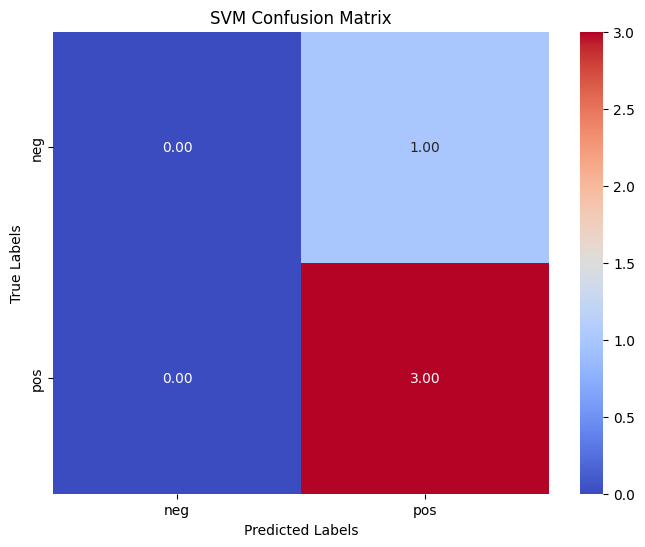

In [44]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Initialize a list to store metrics for each model
metrics = []

# Evaluate on the testing set
for model_name, model_info in results.items():
    print(f"\nEvaluating {model_name} on the test set...")
    best_model = model_info['grid_search'].best_estimator_
    predictions = best_model.predict(X_test)  # Predict on the testing set

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, pos_label='pos')  # Use average='weighted' for multi-class
    recall = recall_score(y_test, predictions, pos_label='pos')  # "" ""

    # Append metrics to the list
    metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall
    })

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Recall: {recall:.2f}")

    # Create a confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [45]:
# Create a DataFrame for comparison
metrics_df = pd.DataFrame(metrics)

# Display the metrics comparison
print("\nMetrics Comparison:")
print(metrics_df)

# Save metrics to a CSV file
metrics_df.to_csv("model_metrics_comparison.csv", index=False)


Metrics Comparison:
                 Model  Accuracy  F1 Score  Recall
0          Naive Bayes      0.75  0.857143     1.0
1  Logistic Regression      0.75  0.857143     1.0
2                  SVM      0.75  0.857143     1.0


# Results

After fine-tuning the models, the overall performance for the logistic regression and SVM models were decent, while the NB model performance was average/poor. LR and SVM models appear to be slightly overfit, as they were excellent at identifying positive cases but were less performant with false positives. The NB model had much lower recall than the other two, suggesting that it was missing some positive cases. Given more time, I'd further investigate the TFIDF scores, expand the stop words list and utilize SMOTE to handle the imbalanced data, instead of leaning so much into implementing the MultinomialNB model.

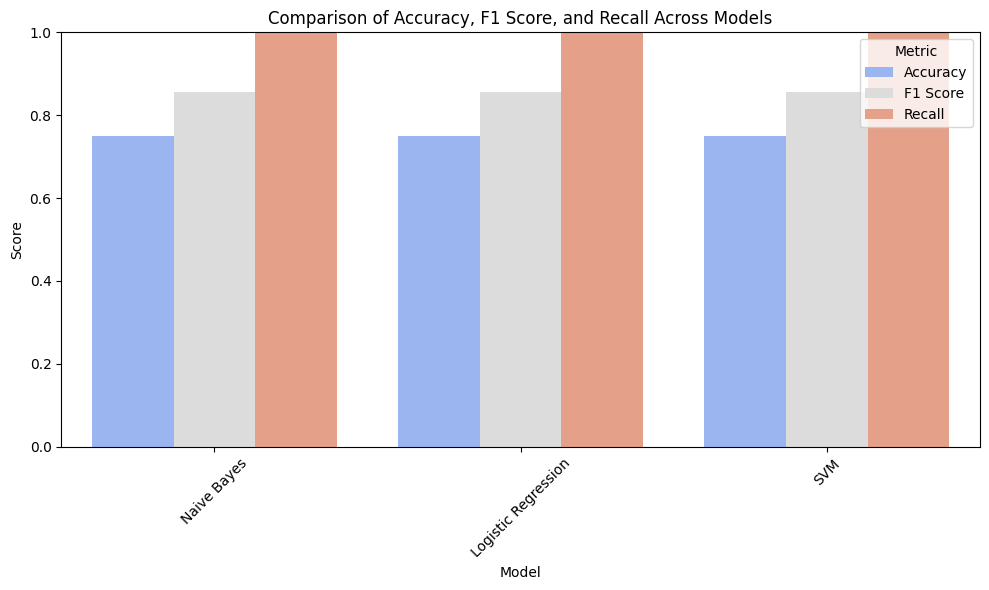

In [46]:
# Melt the DataFrame for easy plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric', palette='coolwarm')

plt.title("Comparison of Accuracy, F1 Score, and Recall Across Models")
plt.ylabel("Score")
plt.ylim(0, 1)  # Assuming scores range from 0 to 1
plt.xlabel("Model")
plt.legend(title="Metric", loc="upper right")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

In [47]:
# Save metrics to a CSV file
metrics_df.to_csv("model_metrics_comparison.csv", index=False)

**Troubleshooting NB performance**

Initially the other models were performing decently but NB only had 25% accuracy and 0% recall and 0% f1. Upon reviewing the top features several had tfidf weights of 0, so I removed those from the tokens and added them as stopwords, which greatly improved it's performance, though it still didn't reach the same performance of the other two.  

In [48]:
"""
# Retrieve the best Naive Bayes model
nb_model = results['Naive Bayes']['grid_search'].best_estimator_

# Get predictions and compare them with the true labels
nb_predictions = nb_model.predict(X_test)

# Create a DataFrame to inspect predictions
prediction_analysis = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': nb_predictions
})

# Display mismatches
print("Mismatched Predictions:")
print(prediction_analysis[prediction_analysis['True Label'] != prediction_analysis['Predicted Label']])
"""

'\n# Retrieve the best Naive Bayes model\nnb_model = results[\'Naive Bayes\'][\'grid_search\'].best_estimator_\n\n# Get predictions and compare them with the true labels\nnb_predictions = nb_model.predict(X_test)\n\n# Create a DataFrame to inspect predictions\nprediction_analysis = pd.DataFrame({\n    \'True Label\': y_test,\n    \'Predicted Label\': nb_predictions\n})\n\n# Display mismatches\nprint("Mismatched Predictions:")\nprint(prediction_analysis[prediction_analysis[\'True Label\'] != prediction_analysis[\'Predicted Label\']])\n'

In [49]:
"""
# Inspect class distribution
print("Class distribution in y_test:")
print(y_test.value_counts())
"""

'\n# Inspect class distribution\nprint("Class distribution in y_test:")\nprint(y_test.value_counts())\n'

In [50]:
"""
# Get predicted probabilities
nb_probabilities = nb_model.predict_proba(X_test)

# Inspect the first few probabilities
print("Predicted Probabilities (First 5):")
print(pd.DataFrame(nb_probabilities, columns=nb_model.classes_).head())
"""

'\n# Get predicted probabilities\nnb_probabilities = nb_model.predict_proba(X_test)\n\n# Inspect the first few probabilities\nprint("Predicted Probabilities (First 5):")\nprint(pd.DataFrame(nb_probabilities, columns=nb_model.classes_).head())\n'

In [51]:
"""
# Inspect the vocabulary of the TfidfVectorizer
vectorizer = nb_model.named_steps['vectorizer']
print("Top 10 Features by TF-IDF Score:")
print(pd.DataFrame(vectorizer.transform(X_test).toarray(), columns=vectorizer.get_feature_names_out()).head(10))
"""

'\n# Inspect the vocabulary of the TfidfVectorizer\nvectorizer = nb_model.named_steps[\'vectorizer\']\nprint("Top 10 Features by TF-IDF Score:")\nprint(pd.DataFrame(vectorizer.transform(X_test).toarray(), columns=vectorizer.get_feature_names_out()).head(10))\n'

# Conclusion

Overall these models performed decently for this sentiment analysis classification task. It was able to perform better than guessing when it came to analyzing social media sentiment of AI, but there is still alot of room for improvement and optimization. Additional data, along with more expanisive finetuning could have an positive effect on the performance of all of the models, potentially boosting both accuracy and f1 scores.

In [53]:
# Creating HTML file in colab

%%shell
jupyter nbconvert --to html /content/Nikita_Ramsey_W2_HW2(1).ipynb

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `jupyter nbconvert --to html /content/Nikita_Ramsey_W2_HW2(1).ipynb'


CalledProcessError: Command 'jupyter nbconvert --to html /content/Nikita_Ramsey_W2_HW2(1).ipynb
' returned non-zero exit status 2.